In [1]:
# Ejecutar solo si usas Colab o no tienes las librerías
!pip install -q causalgraphicalmodels statsmodels pandas numpy matplotlib networkx

In [2]:
import os
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Intento usar causalgraphicalmodels para dibujar el DAG; si no, uso networkx
try:
    from causalgraphicalmodels import CausalGraphicalModel
    CAN_DRAW_DAG = True
except Exception:
    CAN_DRAW_DAG = False

OUT_DIR = "Python_output_part3"
os.makedirs(OUT_DIR, exist_ok=True)

np.random.seed(2025)

In [3]:
# Parámetros
n = 2000         # observaciones
n_sims = 200     # simulaciones para el plot comparativo
true_beta = 2.0  # efecto verdadero X -> Y

def simulate_data_image_dag(n, z_affects_x=False):
    """
    Simula datos para el DAG de la imagen:
      U1 -> X
      U1 -> Z
      U2 -> Z
      U2 -> Y
      Z  -> Y
      X  -> Y
    Si z_affects_x=True añadimos Z -> X (escenario modificado).
    """
    U1 = np.random.normal(size=n)
    U2 = np.random.normal(size=n)
    eps_x = np.random.normal(scale=1.0, size=n)
    eps_y = np.random.normal(scale=1.0, size=n)
    eps_z = np.random.normal(scale=1.0, size=n)

    if not z_affects_x:
        # Escenario inicial (imagen): Z no -> X
        X = 0.8 * U1 + 0.4 * np.random.normal(size=n)  + eps_x   # X depende fuertemente de U1 (y algo de ruido)
        Z = 0.6 * U1 + 0.7 * U2 + eps_z                           # Z conectado a U1 y U2 (collider U1<-Z->U2)
    else:
        # Escenario modificado: añadimos Z -> X
        Z = 0.6 * U1 + 0.7 * U2 + eps_z
        X = 0.8 * U1 + 0.5 * Z + eps_x     # ahora Z influye en X también

    Y = true_beta * X + 0.5 * U1 + 0.6 * U2 + eps_y

    df = pd.DataFrame({'Y': Y, 'X': X, 'Z': Z, 'U1': U1, 'U2': U2})
    return df

In [4]:
def run_comparison(n_sims=200, n=2000, z_affects_x=False):
    coef_no_z = []
    se_no_z = []
    coef_with_z = []
    se_with_z = []
    for i in range(n_sims):
        df = simulate_data_image_dag(n, z_affects_x=z_affects_x)
        m1 = sm.OLS(df['Y'], sm.add_constant(df[['X']])).fit()
        coef_no_z.append(m1.params['X']); se_no_z.append(m1.bse['X'])
        m2 = sm.OLS(df['Y'], sm.add_constant(df[['X','Z']])).fit()
        coef_with_z.append(m2.params['X']); se_with_z.append(m2.bse['X'])
    return pd.DataFrame({
        'coef_no_z': coef_no_z,
        'se_no_z': se_no_z,
        'coef_with_z': coef_with_z,
        'se_with_z': se_with_z
    })

# Ejecutar para el escenario de la imagen (sin Z->X)
res_base = run_comparison(n_sims=n_sims, n=n, z_affects_x=False)

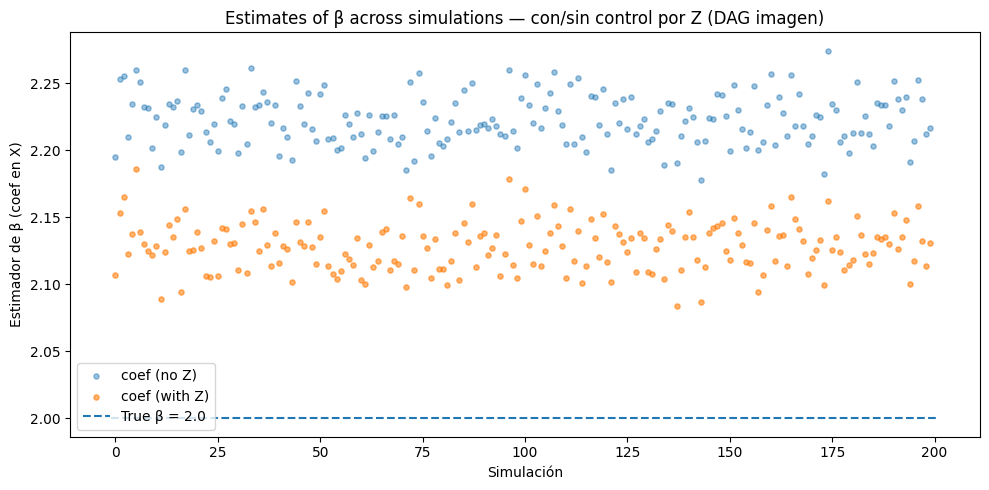

Saved: Python_output_part3/coef_plot_image_dag.png


In [5]:
plt.figure(figsize=(10,5))
plt.scatter(range(len(res_base)), res_base['coef_no_z'], alpha=0.45, label='coef (no Z)', s=14)
plt.scatter(range(len(res_base)), res_base['coef_with_z'], alpha=0.6, label='coef (with Z)', s=14)
plt.hlines(true_beta, xmin=-1, xmax=len(res_base)+1, linestyles='--', label=f"True β = {true_beta}")
plt.xlabel("Simulación")
plt.ylabel("Estimador de β (coef en X)")
plt.legend()
plt.title("Estimates of β across simulations — con/sin control por Z (DAG imagen)")
plt.tight_layout()
plot_path = os.path.join(OUT_DIR, "coef_plot_image_dag.png")
plt.savefig(plot_path, dpi=150)
plt.show()
print("Saved:", plot_path)

In [6]:
# Simular un dataset con Z -> X (escenario modificado)
df_mod = simulate_data_image_dag(n=n, z_affects_x=True)

controls = ['Z','U1','U2']
combos = []
for r in range(len(controls)+1):
    for subset in itertools.combinations(controls, r):
        combos.append(list(subset))

results = []
for subset in combos:
    X_vars = ['X'] + subset
    mod = sm.OLS(df_mod['Y'], sm.add_constant(df_mod[X_vars])).fit()
    results.append({
        'controls': ','.join(subset) if subset else '(none)',
        'β': mod.params['X'],
        'SE': mod.bse['X']
    })

est_df = pd.DataFrame(results).set_index('controls')
est_df = est_df.sort_index()
est_df

,β,SE
controls,,
(none),2.310795,0.016632
U1,2.171138,0.022344
"U1,U2",2.002820,0.019781
U2,2.223980,0.015050
Z,2.142842,0.020935
"Z,U1",1.997397,0.025326
"Z,U1,U2",2.003784,0.022266
"Z,U2",2.207565,0.019364


In [7]:
txt_path = os.path.join(OUT_DIR, "est_se_table_image_dag.txt")
tex_path = os.path.join(OUT_DIR, "est_se_table_image_dag.tex")
est_df.to_csv(txt_path, sep='\t', float_format='%.6f')
print("Saved txt:", txt_path)
# Guardar LaTeX (si puedes)
try:
    with open(tex_path, 'w') as f:
        f.write(est_df.to_latex(float_format="%.4f"))
    print("Saved tex:", tex_path)
except Exception as e:
    print("Could not write .tex:", e)

Saved txt: Python_output_part3/est_se_table_image_dag.txt
Saved tex: Python_output_part3/est_se_table_image_dag.tex


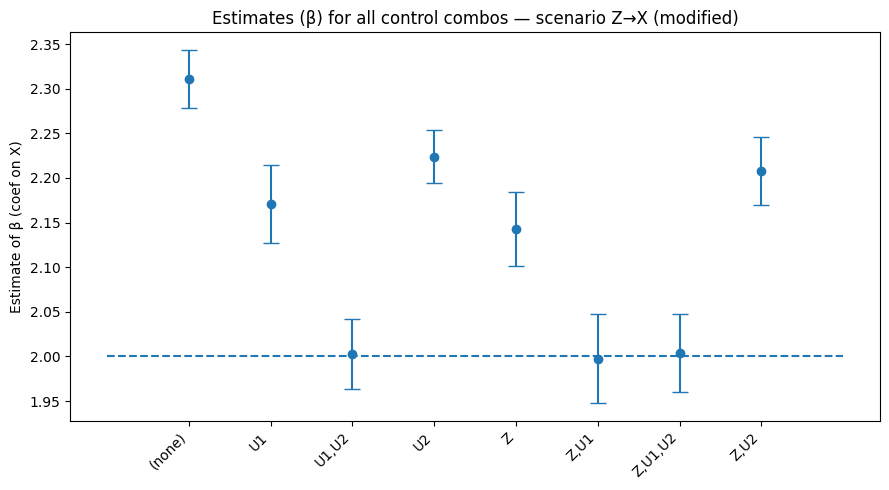

Saved: Python_output_part3/estimates_combo_plot_image_dag.png


In [8]:
plt.figure(figsize=(9,5))
xpos = np.arange(len(est_df))
plt.errorbar(xpos, est_df['β'], yerr=1.96*est_df['SE'], fmt='o', capsize=6)
plt.hlines(true_beta, xmin=-1, xmax=len(est_df), linestyles='--', label=f"True β = {true_beta}")
plt.xticks(xpos, est_df.index, rotation=45, ha='right')
plt.ylabel('Estimate of β (coef on X)')
plt.title('Estimates (β) for all control combos — scenario Z→X (modified)')
plt.tight_layout()
plot2_path = os.path.join(OUT_DIR, "estimates_combo_plot_image_dag.png")
plt.savefig(plot2_path, dpi=150)
plt.show()
print("Saved:", plot2_path)

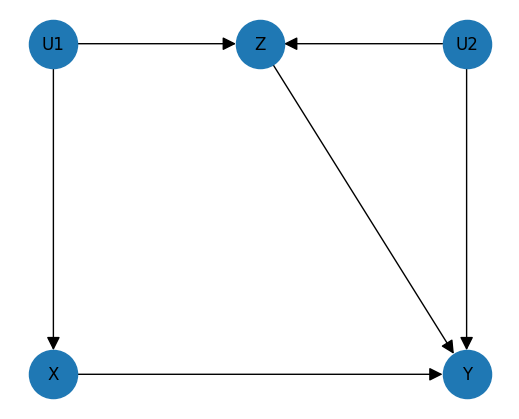

Saved DAG: Python_output_part3/dag_image_simple.png


In [9]:
# Intento dibujar el DAG de la imagen (sin Z->X)
if CAN_DRAW_DAG:
    dag = CausalGraphicalModel(
        nodes=['U1','U2','Z','X','Y'],
        edges=[('U1','X'),('U1','Z'),('U2','Z'),('U2','Y'),('Z','Y'),('X','Y')]
    )
    fig = dag.draw()
    dag_path = os.path.join(OUT_DIR,"dag_image.png")
    fig.savefig(dag_path, dpi=150)
    print("Saved DAG:", dag_path)
else:
    import networkx as nx
    G = nx.DiGraph()
    G.add_edges_from([('U1','X'),('U1','Z'),('U2','Z'),('U2','Y'),('Z','Y'),('X','Y')])
    pos = {'U1':(-1,1),'U2':(1,1),'Z':(0,1),'X':(-1,-1),'Y':(1,-1)}
    plt.figure(figsize=(5,4))
    nx.draw(G, pos, with_labels=True, arrowsize=20, node_size=1200)
    dag_path = os.path.join(OUT_DIR,"dag_image_simple.png")
    plt.savefig(dag_path, dpi=150)
    plt.show()
    print("Saved DAG:", dag_path)